# Sign Language Classification

### Dataset Source
https://www.kaggle.com/datamunge/sign-language-mnist

### Dataset Description

In this project I am using a dataset that contains images (actually their grayscale pixel values); each image represents a certain letter from A to Y in the sign language.
The dataset does not contain any data on J or Z letters, as those have **motion** involved
when translated into sign language. Images are 28 by 28 pixels, and there are a total of 34627 of them in the dataset.

If one is interested in learning more about this they can visit the following page where they can translate text into how it would look in the sign language:
https://wecapable.com/tools/text-to-sign-language-converter/.


### Motivation

After doing some research on this topic, I did not find a lot of applications that would do the reverse, i.e. translate images of signs into what they mean in English. Therefore, I decided to utilize some image processing techniques along with different classification algorithms to accomplish this task, although only with digits for now.

### Goal

My goal in this project is to compare the accuracies on the test set of the following models:
SVM, MLP, and CNN. I expect CNN to perform better than the two other models, as Convolutional Neural Networks have proved to be more efficient in image classification tasks. Another goal is to build some kind of majority-vote ensemble, where the decision of the model with the highest accuracy, will be "vetoed" if the other two models' predictions are the same and differ from that of the best performing model. I decided to go with this ensemble model instead of the usual majority-vote ensemble, due to - as will be seen below - low test accuracy of one of the models.

### Tensorflow

Note that this project uses tensorflow in order to build a CNN model; therefore, tensorflow
needs to be installed using *pip* for example.

## Preparing the Dataset

Here, we take the csv files that contain train and test data for our application.
Some basic imports of numpy and matplotlib.pyplot are also done and will be used along the way

In [1]:
############################################
# Using a dataset with 
# Letters instead of Digits in Sign Language
############################################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## loading the csv file
X_TRAIN = pd.read_csv('./sign_mnist_train.csv')
X_TEST = pd.read_csv('./sign_mnist_test.csv')

### Getting the feature matrices and target vectors

We also adjust the target vectors so that all labels of 24 get the value of 9, to account
for the missing J letter in the middle of the alphabet (the reason behind this was explained above).

In [2]:
############################################
# NOTE: I am changing target value of 24 to 9
# because the value 9 is skipped 
# in possible target values
############################################

## getting the target vector for training set
target_train = X_TRAIN["label"]
target_train[target_train == 24] = 9
target_train = target_train.to_numpy()

## getting the feature matrix for training set
feature_matrix_train = X_TRAIN.drop("label", axis=1)
feature_matrix_train = feature_matrix_train.to_numpy() / 255

## getting the target vector for testing set
target_test = X_TEST["label"]
target_test[target_test == 24] = 9
target_test = target_test.to_numpy()

## getting the feature matrix for testing set
feature_matrix_test = X_TEST.drop("label", axis=1)
feature_matrix_test = feature_matrix_test.to_numpy() / 255

### Getting familiar with a sample

Here we take a single example feature vector that contains a flattened list of 
pixel grayscale values. We, then, reshape this vector into a 28x28 matrix to display it
with the help of plt.imshow()

The target of this example is:  3


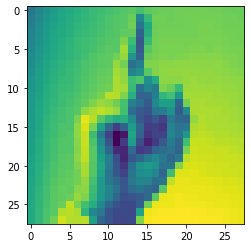

In [3]:
############################################
# Taking a look at an example image
############################################

## Here I am also going to initialize a variable IMG_SIZE
## which I 'll use later as well
## it is just the number of pixels on each side of a square image
IMG_SIZE = 28

plt.imshow(feature_matrix_train[0].reshape((IMG_SIZE, IMG_SIZE)))

print("The target of this example is: ", target_train[0])

As we can see in the image below that example 
above corresponds to the letter D, i.e. 3, 
cause we start counting labels from 0

In [4]:
############################################
# Because A - 0, B - 1, C - 2, and D - 3
# We can conclude that the target of the above feature vector makes sense
############################################

![image](./amer_sign2.png)

Here we are importing SVC for the SVM model, PCA (Principal Component Analysis) for feature extraction, and other modules for building pipelines and assesing a model

In [5]:
# model imports - sklearn
from sklearn.svm import SVC

# dimensionality reduction
from sklearn.decomposition import PCA

# pipeline
from sklearn.pipeline import make_pipeline

# for k-fold cross validation
from sklearn.model_selection import cross_val_score 

# SVM model

In [6]:
############################################
# Building a pipeline with SVM and PCA
############################################

pipe_svm = make_pipeline(PCA(n_components=50, random_state=1),
                         SVC(kernel='rbf', C=10, gamma='scale', random_state=1))

In [7]:
############################################
# features and targets are in the right format
# so we don't change anything for those here
############################################

X_train = feature_matrix_train
y_train = target_train

X_test = feature_matrix_test
y_test = target_test

Here I am running a K-fold cross validation to tweak the regularization of the SVM model
,and I got the highest accuracy when C=10

In [8]:
############################################
# K fold cross validation (k = 10)
############################################

scores_svm = cross_val_score(estimator=pipe_svm,
                          X=X_train,
                          y=y_train,
                          cv=10,
                          n_jobs=-1) ## using all CPUs
print('CV accuracy scores: %s' % scores_svm)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_svm), np.std(scores_svm)))

CV accuracy scores: [1.         1.         1.         1.         0.99963583 1.
 1.         1.         1.         1.        ]
CV accuracy: 1.000 +/- 0.000


In [9]:
## fitting the model with the training data

pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=50, random_state=1)),
                ('svc', SVC(C=10, random_state=1))])

In [10]:
from sklearn.metrics import accuracy_score

y_pred_svm = pipe_svm.predict(X_test)

print("accuracy: " + str(accuracy_score(y_test, y_pred_svm)))

accuracy: 0.8784160624651423


We can see the model is somewhat overfitting the data, as observed from the discrepancy between the validation and test accuracy scores. Nevertheless, as we 'll see a bit later, this result is actually good enough.

# Convolutional Neural Network

Because we are using a Convolution Neural Network for image classification, we need to reshape our feature matrices so that they have the following final shapes (# of examples, 28 ,28, 1) - where the last dimension is 1 as we are using grayscale pixel values.

Following this we join targets with feature matrices in tensorflow Datasets and batch them. (done for the test set a bit later)

In [11]:
import tensorflow as tf

############################################
# getting the data into the right shape
############################################

# feature matrices have to be adjusted
# removed ONE from dim
X_train_cnn = feature_matrix_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

X_validation_cnn = X_train_cnn[:2746]
X_train_cnn = X_train_cnn[2746:]

X_test_cnn = feature_matrix_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# target vectors are unchanged
y_train_cnn = target_train

y_validation_cnn = y_train_cnn[:2746]
y_train_cnn = y_train_cnn[2746:]

y_test_cnn = target_test

## putting everything into a Tensorflow Dataset
X_train_cnn_new = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
X_train_cnn_new = X_train_cnn_new.batch(32)

validation_cnn_new = tf.data.Dataset.from_tensor_slices((X_validation_cnn, y_validation_cnn))
validation_cnn_new = validation_cnn_new.batch(32)

Notice that above we are also creating a validation set from the ten percent of the training set

Now, we are creating a Sequantial model using Keras, which is a wrapper around he Tensorflow,
and we add layers to this model.

The first three layers include Convolutional 2D and Max Pooling layers.
Following this we flatten the input into two more "dense" layers.
Only the last layer has softmax activation units (to get probability values in an OvR kind of sense).
All other layers have Rectified Linear Unit activation functions which have proved to lead to better results in CNNs

In [12]:
from tensorflow.keras import models, layers

#### initialize a sequential model
cnn = models.Sequential()

#### 1st convolutional and pooling layers
#### Note: the input size is (28, 28, 1)
cnn.add(layers.Conv2D(filters=IMG_SIZE, kernel_size=(3, 3),
                          activation='relu',
                          input_shape=(IMG_SIZE, IMG_SIZE, 1)))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

#### 2nd convolutional and pooling layers

cnn.add(layers.Conv2D(filters=128, kernel_size=(3, 3),
                          activation='relu'))

cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

#### 3rd convolutional and pooling layers
cnn.add(layers.Conv2D(filters=64, kernel_size=(3, 3),
                          activation='relu'))
cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

# flattening layer here, as no more Conv2D layers
cnn.add(layers.Flatten())

# dense layers
cnn.add(layers.Dense(units=64, activation='relu'))
cnn.add(layers.Dense(units=24, activation='softmax'))

# print the summary of the model
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       32384     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [13]:
# Performing the build operation on CNN model
tf.random.set_seed(13)
cnn.build(input_shape=(None, IMG_SIZE, IMG_SIZE, 1))

Here we are using the Adam optimizer which will adjust the regularization parameters by default

In [14]:
# compiling the model to tensorflow from keras
cnn.compile(optimizer='adam', 
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['sparse_categorical_accuracy'])

Now we are fitting the model by putting the the tensorflow Dataset we created earlier and letting the model train over 5 epochs

In [15]:
####################
# Fitting
####################
cnn.fit(X_train_cnn_new, validation_data=validation_cnn_new, epochs=5)

Epoch 1/5
773/773 [==============================] - 9s 11ms/step - loss: 1.5327 - sparse_categorical_accuracy: 0.5128 - val_loss: 0.5984 - val_sparse_categorical_accuracy: 0.8044
Epoch 2/5
773/773 [==============================] - 9s 12ms/step - loss: 0.4102 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.2148 - val_sparse_categorical_accuracy: 0.9421
Epoch 3/5
773/773 [==============================] - 9s 12ms/step - loss: 0.1400 - sparse_categorical_accuracy: 0.9624 - val_loss: 0.0579 - val_sparse_categorical_accuracy: 0.9920
Epoch 4/5
773/773 [==============================] - 11s 14ms/step - loss: 0.0476 - sparse_categorical_accuracy: 0.9903 - val_loss: 0.0249 - val_sparse_categorical_accuracy: 0.9964
Epoch 5/5
773/773 [==============================] - 10s 13ms/step - loss: 0.0264 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.0129 - val_sparse_categorical_accuracy: 0.9978


As we can see it looks like our model has the maximum accuracy on the validation set
So now, let's actually see what the accuracy is on the test set

In [16]:
##############################
# Evaluation of the Test Set
##############################

testing_dataset = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_cnn)).batch(32)


loss, accuracy = cnn.evaluate(testing_dataset, verbose=1)

print("----------------")
print("Test Loss: ")
print(loss)
print("----------------")
print("Test Accuracy: ")
print(accuracy)

225/225 [==============================] - 1s 3ms/step - loss: 0.4315 - sparse_categorical_accuracy: 0.8830
----------------
Test Loss: 
0.4315030574798584
----------------
Test Accuracy: 
0.8830173015594482


We get something similar to what we had with the SVM model, where the Test Accuracy is not well predicted by the Validation Accuracy score.

An explanation to this could be that the dataset that I took from the source given at the top of the notebook is itself already divided into a test and a training sets, which means that they might end up having some general differences in them; and this might evetually lead to some overfitting of the training data

# MLP model

Finally, let's test the MultiLayer Perceptron model. Note MLP model was also tested in the Prototype assignment, although without Principal Component Analysis. (it performed poorly due to a large number of features)

Here we create a pipeline from PCA and the MLPClassifier:

In [17]:
##################################
# Building the MLP and PCA pipe
##################################

from sklearn.neural_network import MLPClassifier
pipe_mlp = make_pipeline(PCA(n_components=100, random_state=1),
                         MLPClassifier(solver='adam', 
                                       alpha=1e-5, 
                                       hidden_layer_sizes=(100, 100, 50), 
                                       random_state=1))

Because the MLPClassifier requires targets to be one hot encoded, we need to adapt our target vectors.

In [18]:
##########################################
# Getting the data into the right
# format by making targets one hot encoded
##########################################

y_list = y_train_cnn.tolist()
y_list_validation = y_validation_cnn.tolist()
y_list_test = y_test_cnn.tolist()

In [19]:
for i, label in enumerate(y_list):
    y_list[i] = np.zeros(24)
    y_list[i][label] = 1

for i, label in enumerate(y_list_test):
    y_list_test[i] = np.zeros(24)
    y_list_test[i][label] = 1
    
for i, label in enumerate(y_list_validation):
    y_list_validation[i] = np.zeros(24)
    y_list_validation[i][label] = 1

In [20]:
## targets in the right format
y_train_mlp = np.array(y_list)
y_validation_mlp = np.array(y_list_validation)
y_test_mlp = np.array(y_list_test)

In [21]:
####################
# Fitting
####################
pipe_mlp.fit(X_train_cnn.reshape(-1, IMG_SIZE * IMG_SIZE), y_train_mlp)

Pipeline(steps=[('pca', PCA(n_components=100, random_state=1)),
                ('mlpclassifier',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(100, 100, 50),
                               random_state=1))])

In [22]:
##############################
# Evaluation of the Validation Set
##############################

y_valid_mlp_pred = pipe_mlp.predict(X_validation_cnn.reshape(-1, IMG_SIZE * IMG_SIZE))

print("Validation accuracy: " + str(accuracy_score(y_validation_mlp, y_valid_mlp_pred)))

Validation accuracy: 1.0


In [23]:
##############################
# Evaluation of the Test Set
##############################

y_pred_mlp = pipe_mlp.predict(X_test)

print("Validation accuracy: " + str(accuracy_score(y_test_mlp, y_pred_mlp)))

Validation accuracy: 0.6466815393195762


We can conclude here that CNN and SVM perform better than the MLP model for this dataset. Moreover, the fact that, in the case of MLP, we also observe overfitting, further supports the claim I made above after seeing the discrepancy between Validation and Training Accuracies of SVM and CNN models

# Estimating Majority Vote Ensemble Accuracy

Here, I am performing several operations on the predicted target vectors from the three models above to estimate if the ensemble model I mentioned in the intro section would improve the accuracy we saw from SVM and CNN.

Thus, if the predicted labels of SVM and MLP match and are different from that of CNN, then the ensemble "votes" for the SVM/MLP label. Otherwise, we go for CNN's predicted label

In [24]:
###############################################
# Building my own Majority Vote Ensemble 
# For accuracy prediction of the test data
###############################################

def predict_majority_vote_accuracy():
    cnn_pred = np.argmax(cnn.predict(testing_dataset), axis=1)
    svm_pred = pipe_svm.predict(X_test)
    mlp_pred = np.argmax(pipe_mlp.predict(X_test), axis=1)
    
    set_pred = np.vstack((cnn_pred, svm_pred, mlp_pred)).tolist()
    
    vote_pred = []
    
    for i in range(cnn_pred.size):
        toAppend = set_pred[0][i]
        if set_pred[1][i] == set_pred[2][i]:
            toAppend = set_pred[1][i]
        vote_pred.append(toAppend)
        
    final_vote = np.array(vote_pred)
    print("accuracy: " + str(accuracy_score(y_test, final_vote)))
            

In [25]:
predict_majority_vote_accuracy()

accuracy: 0.8824595649749024


Although the estimate of the testing accuracy of this ensemble is slightly higher than those of SVM and CNN, the difference is really insignificant. Therefore, one might just use CNN (in practice, if we have larger feature vectors than here, we should expect the accuracy of SVM to decrease relative to CNN) for an application where we want to translate sign language into English, for example.

Something that can be done to actually fully develop such an application would be to introduce object and motion detection to be able to locate a hand in an image with more objects around it and to enable the translation of signs that involve motion, e.g. letters I and Z, as was mentioned in the introduction.